In [1]:
# Predictive analytics for cruises

In [2]:
import findspark

In [3]:
findspark.init('/home/lakshmi/spark-2.4.5-bin-hadoop2.7')

In [4]:
from pyspark.sql import SparkSession

In [5]:
from pyspark.sql.functions import isnull, sum

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
spark = SparkSession.builder.appName("cruise").getOrCreate()

In [8]:
df1 = spark.read.csv("/media/sf_Ubuntu_Shared/cruise_ship_info.csv", inferSchema=True, header=True)

In [9]:
df1.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [10]:
df1.count()

158

In [11]:
# Check if there are missing values
for col in df1.columns:
    df1.select(isnull(col).alias(col)).groupBy(col).count().show()    

+---------+-----+
|Ship_name|count|
+---------+-----+
|    false|  158|
+---------+-----+

+-----------+-----+
|Cruise_line|count|
+-----------+-----+
|      false|  158|
+-----------+-----+

+-----+-----+
|  Age|count|
+-----+-----+
|false|  158|
+-----+-----+

+-------+-----+
|Tonnage|count|
+-------+-----+
|  false|  158|
+-------+-----+

+----------+-----+
|passengers|count|
+----------+-----+
|     false|  158|
+----------+-----+

+------+-----+
|length|count|
+------+-----+
| false|  158|
+------+-----+

+------+-----+
|cabins|count|
+------+-----+
| false|  158|
+------+-----+

+-----------------+-----+
|passenger_density|count|
+-----------------+-----+
|            false|  158|
+-----------------+-----+

+-----+-----+
| crew|count|
+-----+-----+
|false|  158|
+-----+-----+



No missing data observed

## Exploratory Data Analysis

In [12]:
df2 = df1.sample(withReplacement=False, fraction=0.5, seed=1) # random sample for histograms

In [13]:
row_list = df2.select('Age', 'Tonnage', 'passengers', 'length', 'cabins',
                     'passenger_density', 'crew').collect()

In [14]:
row_list[0]

Row(Age=6, Tonnage=30.277, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55)

In [15]:
age = [row.Age for row in row_list]
tonnage = [row.Tonnage for row in row_list]
passengers = [row.passengers for row in row_list]
length = [row.length for row in row_list]
cabins = [row.cabins for row in row_list]
passenger_density = [row.passenger_density for row in row_list]
crew = [row.crew for row in row_list]

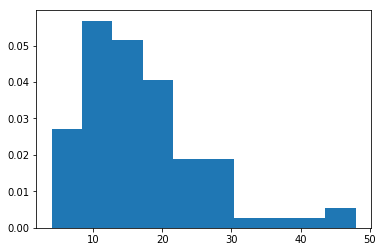

In [16]:
plt.hist(age, density=True)
plt.show()

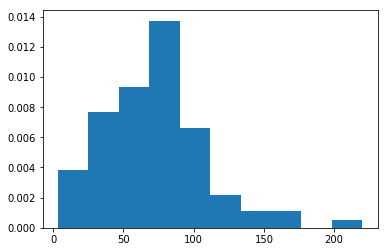

In [17]:
plt.hist(tonnage, density=True)
plt.show()

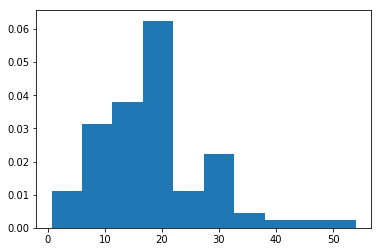

In [18]:
plt.hist(passengers, density=True)
plt.show()

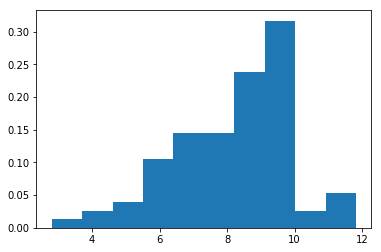

In [19]:
plt.hist(length, density=True)
plt.show()

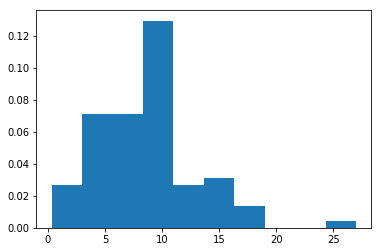

In [20]:
plt.hist(cabins, density=True)
plt.show()

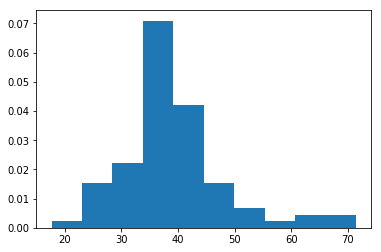

In [21]:
plt.hist(passenger_density, density=True)
plt.show()

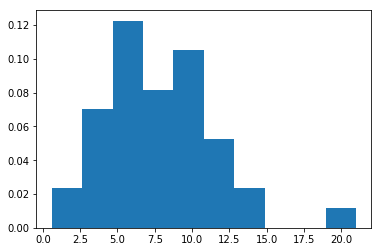

In [22]:
plt.hist(crew, density=True)
plt.show()

Although some features are skewed, the rest have a symmetrical distribution.

Detect and remove outliers

In [23]:
limits_df = pd.DataFrame()

In [24]:
k = 2 #constant for defining upper and lower limits

In [25]:
df1_numeric = df1.drop('Ship_name', 'Cruise_line')

In [26]:
for col in df1_numeric.columns:
    q =  df1.approxQuantile(col, [0.25, 0.75], 0.001)
    IQR = q[1] - q[0]
    lower_limit = q[0] - k * IQR
    upper_limit = q[1] + k * IQR
    limits_df.at['lower',col] = lower_limit
    limits_df.at['upper',col] = upper_limit

In [27]:
limits_df

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
lower,-10.0,-44.0,-12.52,2.25,-3.67,15.31,-3.63
upper,40.0,181.0,50.03,14.35,20.68,63.46,19.07


In [28]:
limits_df.at['lower','Age']

-10.0

In [29]:
for col in df1_numeric.columns:
    df1 = df1.filter((df1[col]>limits_df.at['lower',col]) & (df1[col]<limits_df.at['upper',col]))

In [30]:
df1.count() #count after removing the outliers

148

calculate the correlation between features and target to determine important features

In [31]:
print("Age: ", round(df1.corr('Age', 'crew'), 4))
print("Tonnage: ", round(df1.corr('Tonnage', 'crew'), 4))
print("passengers: ", round(df1.corr('passengers', 'crew'), 4))
print("length: ", round(df1.corr('length', 'crew'), 4))
print("cabins: ", round(df1.corr('cabins', 'crew'), 4))
print("passenger_density: ", round(df1.corr('passenger_density', 'crew'), 4))

Age:  -0.6089
Tonnage:  0.9323
passengers:  0.9147
length:  0.9156
cabins:  0.9549
passenger_density:  -0.0808


Drop passenger_density since it has a weak correlation with the target

## Feature Engineering

In [32]:
from pyspark.ml.feature import StringIndexer

In [33]:
indexer = StringIndexer(inputCol='Cruise_line', outputCol = 'Cruise_label')

In [34]:
cruise_model = indexer.fit(df1)

In [35]:
df3 = cruise_model.transform(df1)

In [36]:
df3.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- Cruise_label: double (nullable = false)



Print the labels for Cruise_line

In [37]:
df3.select('Cruise_line', 'Cruise_label').distinct().orderBy('Cruise_label').show()

+-----------------+------------+
|      Cruise_line|Cruise_label|
+-----------------+------------+
|  Royal_Caribbean|         0.0|
|         Carnival|         1.0|
|         Princess|         2.0|
| Holland_American|         3.0|
|        Norwegian|         4.0|
|            Costa|         5.0|
|        Celebrity|         6.0|
|              MSC|         7.0|
|             Star|         8.0|
|              P&O|         9.0|
|          Oceania|        10.0|
|         Seabourn|        11.0|
|         Windstar|        12.0|
|          Azamara|        13.0|
|           Disney|        14.0|
|Regent_Seven_Seas|        15.0|
|        Silversea|        16.0|
|           Cunard|        17.0|
|          Crystal|        18.0|
+-----------------+------------+



## Split Dataset

In [38]:
from pyspark.ml.feature import VectorAssembler

In [39]:
from pyspark.sql.functions import rand

In [40]:
vecAssembler = VectorAssembler(inputCols = ['Age', 'Tonnage', 'passengers',
                'length', 'cabins', 'passenger_density','Cruise_label'], 
                outputCol = 'features')

In [41]:
df4 = vecAssembler.transform(df3)

In [42]:
df4.show(5)

+-----------+-----------+---+-------+----------+------+------+-----------------+----+------------+--------------------+
|  Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_label|            features|
+-----------+-----------+---+-------+----------+------+------+-----------------+----+------------+--------------------+
|    Journey|    Azamara|  6| 30.277|      6.94|  5.94|  3.55|            42.64|3.55|        13.0|[6.0,30.277,6.94,...|
|      Quest|    Azamara|  6| 30.277|      6.94|  5.94|  3.55|            42.64|3.55|        13.0|[6.0,30.277,6.94,...|
|Celebration|   Carnival| 26| 47.262|     14.86|  7.22|  7.43|             31.8| 6.7|         1.0|[26.0,47.262,14.8...|
|    Destiny|   Carnival| 17|101.353|     26.42|  8.92| 13.21|            38.36|10.0|         1.0|[17.0,101.353,26....|
|    Ecstasy|   Carnival| 22| 70.367|     20.52|  8.55|  10.2|            34.29| 9.2|         1.0|[22.0,70.367,20.5...|
+-----------+-----------+---+-------+---

In [43]:
df5 = df4.orderBy(rand()) # shuffle the dataset

In [44]:
train, test = df5.randomSplit([0.75, 0.25], seed=2)

In [45]:
train.count()

113

In [46]:
test.count()

35

## Fit regression model

In [47]:
from pyspark.ml.regression import LinearRegression

In [48]:
lrRegression = LinearRegression(featuresCol='features', labelCol='crew', predictionCol='prediction',
                maxIter=1000)

In [49]:
lrmodel = lrRegression.fit(train) 

In [50]:
lrmodel.coefficients

DenseVector([0.0009, 0.014, -0.1664, 0.5398, 0.809, -0.0158, 0.0629])

In [51]:
lrmodel.intercept

-1.432724253735195

In [52]:
lrSummary = lrmodel.evaluate(test)

In [53]:
print("Mean Absolute Error: ", lrSummary.meanAbsoluteError)
print("Mean Squared Error: ", lrSummary.meanSquaredError)
print("Root Mean Squared Error: ", lrSummary.rootMeanSquaredError)
print("R2 score: ", lrSummary.r2)

Mean Absolute Error:  0.4704445583147811
Mean Squared Error:  0.3058616120351166
Root Mean Squared Error:  0.5530475676061839
R2 score:  0.9630878844219348


In [54]:
predicted_output = lrmodel.transform(test)

In [55]:
predicted_output.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- Cruise_label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [56]:
lrSummary.predictions

DataFrame[Ship_name: string, Cruise_line: string, Age: int, Tonnage: double, passengers: double, length: double, cabins: double, passenger_density: double, crew: double, Cruise_label: double, features: vector, prediction: double]

In [59]:
lrSummary.predictions.show(5)

+-----------+---------------+---+-------+----------+------+------+-----------------+----+------------+--------------------+------------------+
|  Ship_name|    Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_label|            features|        prediction|
+-----------+---------------+---+-------+----------+------+------+-----------------+----+------------+--------------------+------------------+
|    Artemis|            P&O| 29|   45.0|     11.78|  7.54|   5.3|             38.2| 5.2|         9.0|[29.0,45.0,11.78,...| 5.585428186392052|
| Brilliance|Royal_Caribbean| 11|  90.09|     25.01|  9.62|  10.5|            36.02|8.48|         0.0|[11.0,90.09,25.01...|  8.79740576096967|
|Celebration|       Carnival| 26| 47.262|     14.86|  7.22|  7.43|             31.8| 6.7|         1.0|[26.0,47.262,14.8...|6.2502266208764174|
|       Dawn|       Princess| 16| 77.499|      19.5|  8.56|  10.5|            39.74| 9.0|         2.0|[16.0,77.499,19.5...| 9.037149594608502|

In [58]:
lrSummary.residuals.show(10)

+--------------------+
|           residuals|
+--------------------+
| -0.3854281863920521|
| -0.3174057609696703|
| 0.44977337912358273|
|-0.03714959460850231|
|  0.9740916261298453|
| -1.0085570774677546|
| -0.7592182126437246|
|  0.6546676728319358|
|  0.5956529241923185|
|  0.9160514754716464|
+--------------------+
only showing top 10 rows

